# Integration of Microglia

Integrating microglia of SEAAD and MIT-ROSMAP

In [1]:
import scanpy as sc
import scvi
from ray import tune

In [2]:
# Import files

adata = sc.read_h5ad('merged_microglia.h5ad')


In [3]:
adata

AnnData object with n_obs × n_vars = 154148 × 17818
    obs: 'projid', 'batch', 'individualID', 'species', 'sex', 'race', 'age_death', 'pmi', 'cogdx', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_scores', 'predicted_doublets', 'dataset', 'study', 'educ_years', 'hispanic_latino', 'brain_region', 'apoe_genotype_std', 'apoe_e4_dosage', 'apoe_e4_carrier', 'braak_stage', 'braak_label', 'cerad_score_1_4', 'cerad_score_0_3', 'cerad_label', 'mmse', 'moca', 'casi', 'celltype_major', 'celltype_label', 'celltype_supertype', 'celltype_conf', 'doublet_label', 'harmonized'

# SCVI 

## Installation

In [ ]:
# Verify imports now come from the env path
# 0) Use ONLY the env's site-packages (ignore ~/.local)
import os, sys, site
os.environ["PYTHONNOUSERSITE"] = "1"
try:
    site.ENABLE_USER_SITE = False
except Exception:
    pass
sys.path = [p for p in sys.path if ".local/lib/python" not in p]


In [ ]:
# 1) Upgrade pip tooling inside the env
%pip install -qU pip setuptools wheel


In [ ]:
# 0) Choose a private, writable site-packages and prepend it to sys.path
import sys, os, site, pathlib
LOCAL_TARGET = str(pathlib.Path.home() / ".local" / "scvi-env-packages")
os.makedirs(LOCAL_TARGET, exist_ok=True)

# Keep ~/.local/user-site from interfering
os.environ["PYTHONNOUSERSITE"] = "1"
try:
    site.ENABLE_USER_SITE = False
except Exception:
    pass

if LOCAL_TARGET not in sys.path:
    sys.path.insert(0, LOCAL_TARGET)

print("Using LOCAL_TARGET:", LOCAL_TARGET)
print("sys.path[0]:", sys.path[0])


In [ ]:
# 1) Upgrade pip tooling for this kernel
%pip install -qU --no-cache-dir pip setuptools wheel


In [ ]:
# Inspect what's being imported
import sys, pkgutil
def where(modname):
    try:
        m = __import__(modname)
        return getattr(m, "__version__", "?"), getattr(m, "__file__", "?")
    except Exception as e:
        return None, f"<not importable: {e}>"

print("PYTHONPATH head:", sys.path[0])
for name in ["scvi", "scvi_colab", "scvi_tools", "hyperopt", "flatbuffers"]:
    v, p = where(name)
    print(f"{name}: {v} @ {p}")


In [ ]:
# If you see scvi==0.x from anywhere, uninstall it.
# We'll try both normal and --user uninstalls; ignore "not installed" messages.
%pip uninstall -y scvi
%pip uninstall -y --user scvi


In [ ]:
# Clear pip & conda caches (often GBs)
%pip cache purge || true
%conda clean -a -y || true

# Nuke user caches (safe to remove)
%rm -rf ~/.cache/pip ~/.cache/pyright ~/.cache/matplotlib ~/.cache/* 2>/dev/null || true

# If you’ve downloaded stray wheels or checkpoints in the CWD
%find . -maxdepth 2 -type f -name "*.whl" -delete 2>/dev/null || true
%find ~ -type d -name ".ipynb_checkpoints" -prune -exec rm -rf {} + 2>/dev/null || true


In [ ]:
# Install/refresh scvi-tools (the modern package that imports as 'scvi') into your LOCAL_TARGET
LOCAL_TARGET = "/home/ubuntu/.local/scvi-env-packages"
%pip install -qU --no-cache-dir --target="$LOCAL_TARGET" scvi-tools==1.3.2


In [ ]:
# Verify 'scvi' is now scvi-tools 1.x and coming from LOCAL_TARGET
import scvi, sys
print("scvi version:", scvi.__version__)
print("scvi path:", scvi.__file__)
assert scvi.__version__.split(".")[0] >= "1", "Still loading legacy scvi; need scvi-tools 1.x"
assert scvi.__file__.startswith(LOCAL_TARGET), "scvi not coming from LOCAL_TARGET as intended"


In [ ]:
# Keep your newer hyperopt; the conflict should be gone once legacy 'scvi' is removed
import hyperopt, flatbuffers, scvi_colab
print("hyperopt:", getattr(hyperopt, "__version__", "?"), "from", hyperopt.__file__)
print("flatbuffers:", getattr(flatbuffers, "__version__", "?"), "from", flatbuffers.__file__)
print("scvi_colab from:", scvi_colab.__file__)


In [ ]:
# Finally run the helper
from scvi_colab import install
install()


##  Find hyperparameters and tuner with autotune

In [4]:
print(scvi.__file__)
print(scvi.__version__)

/home/ubuntu/miniconda3/envs/gpu-scvi-env/lib/python3.10/site-packages/scvi/__init__.py
1.3.3


In [5]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata)

In [6]:
search_space = {
    "model_params": {
        "n_hidden": tune.choice([64, 128, 256]),
        "n_layers": tune.choice([1, 2, 3]),
    },
    "train_params": {
        "max_epochs": 30,
        # Training-plan kwargs live under plan_kwargs
        "plan_kwargs": {"lr": tune.loguniform(1e-4, 1e-2)},
    },
}


In [7]:
import ray; ray.shutdown()

from scvi.autotune import run_autotune
from ray import tune

/home/ubuntu/.local/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
exp = run_autotune(
    model_cls=model_cls,
    data=adata,
    metrics=["elbo_validation"],
    mode="min",
    search_space=search_space,
    num_samples=5,
    resources={"cpu": 6, "gpu": 1},
    log_to_driver=False,
)


2025-10-01 19:04:27,263	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/efs/home/ubuntu/human_PFC/integration/scvi_log/scvi_68b14330-996a-412d-8b50-70bf7b9edb58/scvi_68b14330-996a-412d-8b50-70bf7b9edb58' in 0.0639s.
2025-10-01 19:04:27,273	INFO tune.py:1041 -- Total run time: 1791.93 seconds (1791.51 seconds for the tuning loop).


In [9]:
best = exp.result_grid.get_best_result(metric="elbo_validation", mode="max")

In [10]:
best_model_params = best.config["model_params"]
best_train_params = best.config["train_params"]

print("Best model params:", best_model_params)
print("Best train params:", best_train_params)


Best model params: {'n_hidden': 256, 'n_layers': 1}
Best train params: {'max_epochs': 30, 'plan_kwargs': {'lr': 0.005527021905557128}}


In [11]:
df = exp.result_grid.get_dataframe()
# Typical column name for the metric in Ray 2.x:
metric_col = "metrics/elbo_validation" if "metrics/elbo_validation" in df.columns else "elbo_validation"
print(df.sort_values(metric_col, ascending=False).head())

   elbo_validation   timestamp checkpoint_dir_name   done  training_iteration  \
2      6202.752441  1759370454                None   True                   1   
3      6188.558594  1759370534                None   True                   1   
1      6184.077148  1759370371                None   True                   1   
4      6112.685059  1759370667                None   True                   2   
0      5986.126953  1759370281                None  False                  30   

   trial_id                 date  time_this_iter_s  time_total_s    pid  \
2  8c49a0f4  2025-10-01_19-00-54         46.603725     46.603725  32691   
3  f0b3448c  2025-10-01_19-02-14         44.869433     44.869433  32868   
1  c28bf6c5  2025-10-01_18-59-31         46.745365     46.745365  32508   
4  dfcf2a62  2025-10-01_19-04-27         47.353258     96.496066  33110   
0  0aa8ffda  2025-10-01_18-58-01         45.519357   1372.281855  30566   

           hostname        node_ip  time_since_restore  \
2  i

In [12]:
import pandas as pd
df.to_csv('tuning_output.csv', index=False)

In [13]:
exp

Experiment scvi_68b14330-996a-412d-8b50-70bf7b9edb58

ModelTuner will register all tunable hyperparameters in SCVI – these can be viewed by calling info(). By default, this method will display three tables:

Tunable hyperparameters: The names of hyperparameters that can be tuned, their default values, and the internal classes they are defined in.

Available metrics: The metrics that can be used to evaluate the performance of the model. One of these must be provided when running the tuner.

Default search space: The default search space for the model class, which will be used if no search space is provided by the user.

There are a couple more arguments we should be aware of before fitting the tuner:

num_samples: The total number of hyperparameter sets to sample from search_space. This is the total number of models that will be trained.

max_epochs: The maximum number of epochs to train each model for.

        Note: This does not mean that each model will be trained for max_epochs. Depending on the scheduler used, some trials are likely to be stopped early.

resources: A dictionary of maximum resources to allocate for the whole experiment. This allows us to run concurrent trials on limited hardware.

In [14]:
import pandas as pd

rows = []
for result in exp.result_grid:
    # result.metrics_dataframe() returns metrics for all iterations
    df_trial = result.metrics_dataframe
    df_trial["trial_id"] = result.metrics.get("trial_id", result.path)
    df_trial["n_hidden"] = result.config["model_params"]["n_hidden"]
    df_trial["n_layers"] = result.config["model_params"]["n_layers"]
    rows.append(df_trial)

history_df = pd.concat(rows, ignore_index=True)

print(history_df.head())


   elbo_validation   timestamp checkpoint_dir_name   done  training_iteration  \
0      6146.267090  1759368957                None  False                   1   
1      6069.879395  1759369003                None  False                   2   
2      6061.683105  1759369047                None  False                   3   
3      6052.789062  1759369092                None  False                   4   
4      6044.015625  1759369137                None  False                   5   

   trial_id                 date  time_this_iter_s  time_total_s    pid  \
0  0aa8ffda  2025-10-01_18-35-57         48.587164     48.587164  30566   
1  0aa8ffda  2025-10-01_18-36-43         46.074249     94.661413  30566   
2  0aa8ffda  2025-10-01_18-37-27         44.284225    138.945638  30566   
3  0aa8ffda  2025-10-01_18-38-12         44.309821    183.255459  30566   
4  0aa8ffda  2025-10-01_18-38-57         45.802897    229.058356  30566   

           hostname        node_ip  time_since_restore  \
0  i

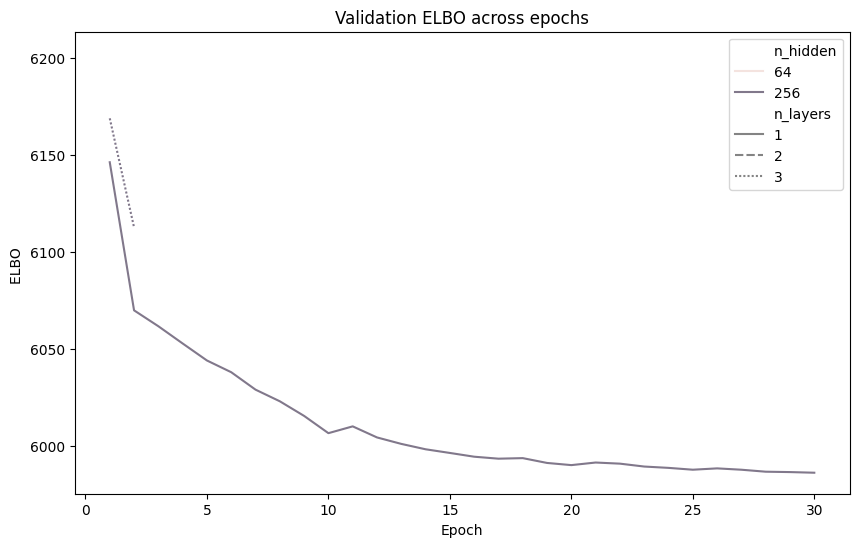

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

metric_col = "elbo_validation" if "elbo_validation" in history_df.columns else "metrics/elbo_validation"

plt.figure(figsize=(10,6))
sns.lineplot(
    data=history_df,
    x="training_iteration",
    y=metric_col,
    hue="n_hidden",
    style="n_layers",
    estimator=None,
    units="trial_id",
    alpha=0.6
)
plt.title("Validation ELBO across epochs")
plt.xlabel("Epoch")
plt.ylabel("ELBO ")
plt.show()


<Axes: xlabel='training_iteration', ylabel='elbo_validation'>

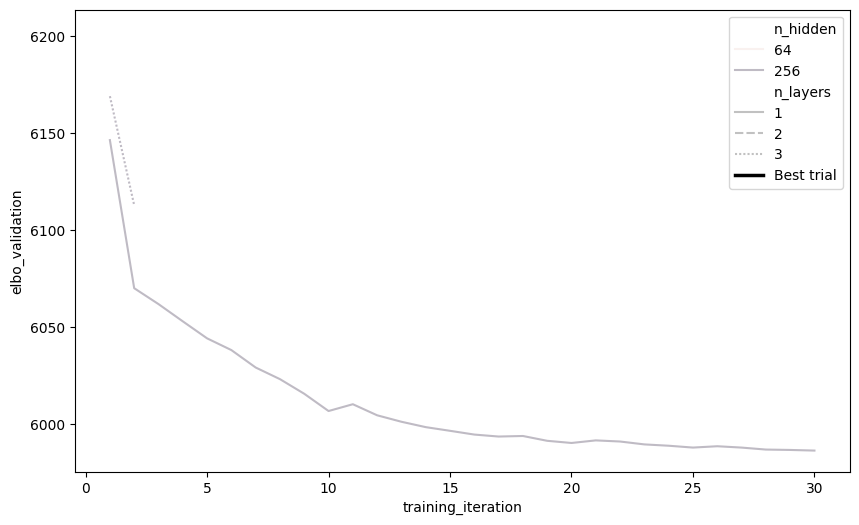

In [16]:
best_id = best.path.split("/")[-1]  # or use best.config
plt.figure(figsize=(10,6))
sns.lineplot(data=history_df, x="training_iteration", y=metric_col,
             hue="n_hidden", style="n_layers", units="trial_id",
             estimator=None, alpha=0.3)
sns.lineplot(data=history_df[history_df["trial_id"] == best_id],
             x="training_iteration", y=metric_col,
             color="black", linewidth=2.5, label="Best trial")


In [17]:
search_space = {
    "model_params": {
        "n_hidden": tune.choice([64, 128, 256]),
        "n_layers": tune.choice([1, 2, 3]),
    },
    "train_params": {
        "max_epochs": 30,
        # Training-plan kwargs live under plan_kwargs
        "plan_kwargs": {"lr": tune.loguniform(1e-4, 5e-3)},
    },
}

import ray; ray.shutdown()

from scvi.autotune import run_autotune
from ray import tune

exp = run_autotune(
    model_cls=model_cls,
    data=adata,
    metrics=["elbo_validation"],
    mode="min",
    search_space=search_space,
    num_samples=5,
    resources={"cpu": 6, "gpu": 1},
    log_to_driver=False,
)


2025-10-01 20:32:17,169	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/efs/home/ubuntu/human_PFC/integration/scvi_log/scvi_920c054c-e7db-49b1-94d8-bce8f20ecf1d/scvi_920c054c-e7db-49b1-94d8-bce8f20ecf1d' in 0.0690s.
2025-10-01 20:32:17,179	INFO tune.py:1041 -- Total run time: 3476.18 seconds (3476.08 seconds for the tuning loop).


In [1]:
best = exp.result_grid.get_best_result(metric="elbo_validation", mode="min")

best_model_params = best.config["model_params"]
best_train_params = best.config["train_params"]

print("Best model params:", best_model_params)
print("Best train params:", best_train_params)

df = exp.result_grid.get_dataframe()
# Typical column name for the metric in Ray 2.x:
metric_col = "metrics/elbo_validation" if "metrics/elbo_validation" in df.columns else "elbo_validation"
print(df.sort_values(metric_col, ascending=False).head())

df.to_csv('tuning_output_2.csv', index=False)

NameError: name 'exp' is not defined

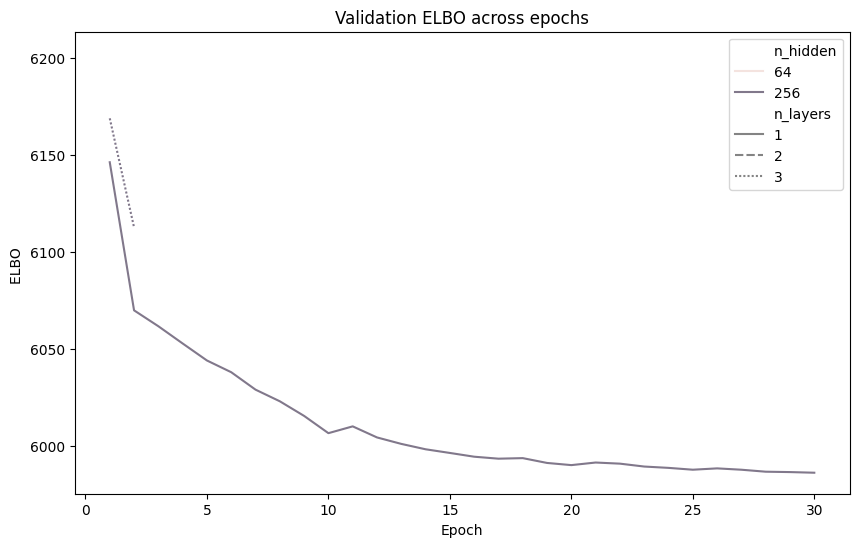

In [19]:


metric_col = "elbo_validation" if "elbo_validation" in history_df.columns else "metrics/elbo_validation"

plt.figure(figsize=(10,6))
sns.lineplot(
    data=history_df,
    x="training_iteration",
    y=metric_col,
    hue="n_hidden",
    style="n_layers",
    estimator=None,
    units="trial_id",
    alpha=0.6
)
plt.title("Validation ELBO across epochs")
plt.xlabel("Epoch")
plt.ylabel("ELBO ")
plt.show()


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your saved results
df = pd.read_csv("tuning_output_2.csv")
print(df.columns)


Index(['elbo_validation', 'timestamp', 'checkpoint_dir_name', 'done',
       'training_iteration', 'trial_id', 'date', 'time_this_iter_s',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'iterations_since_restore', 'config/model_params/n_hidden',
       'config/model_params/n_layers', 'config/train_params/max_epochs',
       'config/train_params/plan_kwargs/lr', 'logdir'],
      dtype='object')


In [3]:
df

,elbo_validation,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/model_params/n_hidden,config/model_params/n_layers,config/train_params/max_epochs,config/train_params/plan_kwargs/lr,logdir
0,6025.477539,1759373969,NaN,False,30,dde525d7,2025-10-01_19-59-29,48.501526,1468.379035,36189,ip-10-90-182-254,10.90.182.254,1468.379035,30,256,3,30,0.003185,dde525d7
1,6089.096680,1759374370,NaN,True,8,512306ab,2025-10-01_20-06-10,44.608344,356.666931,38190,ip-10-90-182-254,10.90.182.254,356.666931,8,64,1,30,0.002762,512306ab
2,5990.512695,1759375761,NaN,False,30,f1aa89ea,2025-10-01_20-29-21,47.583152,1355.339948,38882,ip-10-90-182-254,10.90.182.254,1355.339948,30,128,1,30,0.001900,f1aa89ea
3,6309.392090,1759375853,NaN,True,1,65ed0879,2025-10-01_20-30-53,49.401749,49.401749,40769,ip-10-90-182-254,10.90.182.254,49.401749,1,128,3,30,0.000396,65ed0879
4,6333.502930,1759375937,NaN,True,1,b1079bbc,2025-10-01_20-32-17,48.670422,48.670422,40956,ip-10-90-182-254,10.90.182.254,48.670422,1,64,2,30,0.000602,b1079bbc


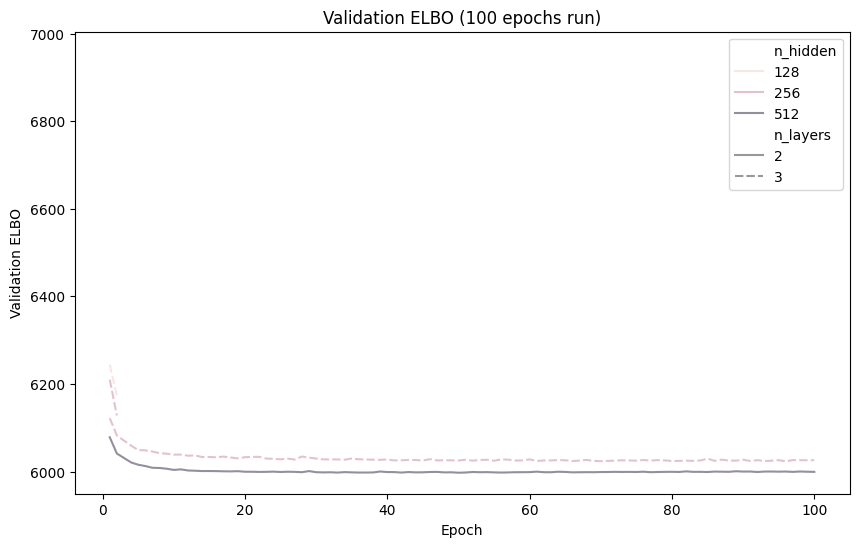

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.read_csv("autotune_results_100/training_histories.csv")

metric_col = "metrics/elbo_validation" if "metrics/elbo_validation" in history_df.columns else "elbo_validation"

plt.figure(figsize=(10,6))
sns.lineplot(
    data=history_df,
    x="training_iteration",
    y=metric_col,
    hue="n_hidden",        # color by hidden size
    style="n_layers",      # style by layer count
    estimator=None,
    units="trial_id",
    alpha=0.5
)
plt.title("Validation ELBO (100 epochs run)")
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()


In [7]:
df = pd.read_csv("autotune_results_100/tuning_output.csv")

# Pick the best row (lowest ELBO)
best_row = df.loc[df["elbo_validation"].idxmin()]

# Extract best hyperparameters
best_model_params = {
    "n_hidden": int(best_row["config/model_params/n_hidden"]),
    "n_layers": int(best_row["config/model_params/n_layers"]),
    "n_latent": int(best_row["config/model_params/n_latent"]),
    "dropout_rate": float(best_row["config/model_params/dropout_rate"]),
}

best_train_params = {
    "max_epochs": int(best_row["config/train_params/max_epochs"]),
    "plan_kwargs": {
        "lr": float(best_row["config/train_params/plan_kwargs/lr"]),
        "n_epochs_kl_warmup": (
            None
            if pd.isna(best_row["config/train_params/plan_kwargs/n_epochs_kl_warmup"])
            else int(best_row["config/train_params/plan_kwargs/n_epochs_kl_warmup"])
        ),
    },
}

print("Best model params:", best_model_params)
print("Best train params:", best_train_params)



Best model params: {'n_hidden': 512, 'n_layers': 2, 'n_latent': 30, 'dropout_rate': 0.1463422937120131}
Best train params: {'max_epochs': 100, 'plan_kwargs': {'lr': 0.0030175780873181, 'n_epochs_kl_warmup': None}}


# Final model

In [13]:
import scanpy as sc
import scvi

In [14]:
adata = sc.read_h5ad('merged_microglia.h5ad')

In [16]:
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
model = scvi.model.SCVI(adata, n_hidden=128, n_layers=1, n_latent=30, gene_likelihood="nb")

model.train(plan_kwargs={"lr": 0.0019}, datasplitter_kwargs={"num_workers": 7}) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/52 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=52` reached.


In [17]:
model.save("scvi_best_model", overwrite=True)

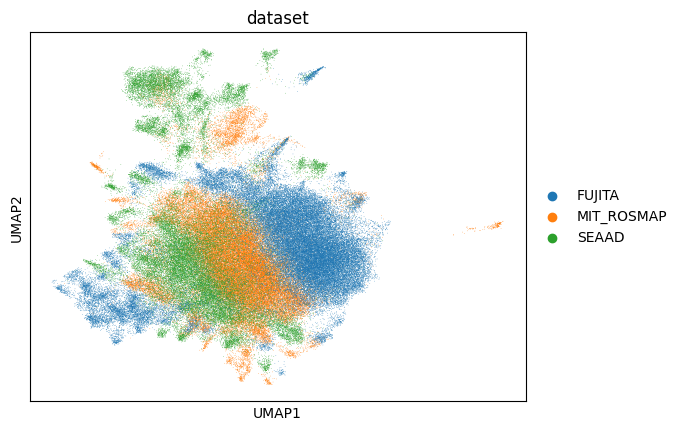

In [19]:
# --- Get latent, neighbors, UMAP, clustering ---
adata.obsm["X_scvi"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["dataset"])       # check batch mixing

Trying different parameters in case this works better.... (based on the results from tuning_output.csv)

In [21]:
adata = sc.read_h5ad('merged_microglia.h5ad')
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
model = scvi.model.SCVI(adata, n_hidden=256, n_layers=1, n_latent=30, gene_likelihood="nb")

model.train(plan_kwargs={"lr": 0.0019}, datasplitter_kwargs={"num_workers": 7}) 

model.save("scvi_model_256_1_0.0019", overwrite=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/52 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=52` reached.


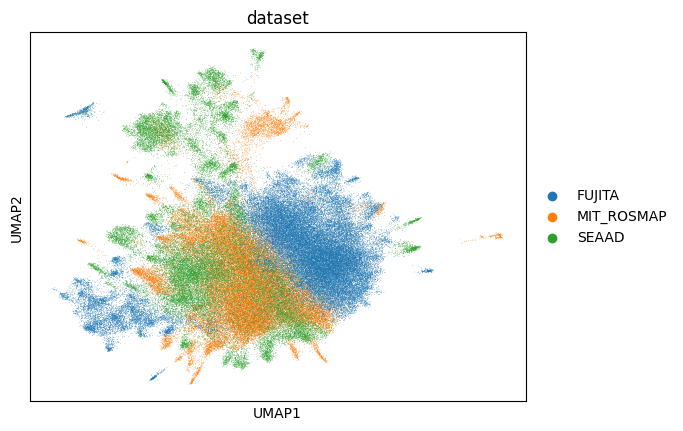

In [22]:
# --- Get latent, neighbors, UMAP, clustering ---
adata.obsm["X_scvi"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["dataset"])       # check batch mixing

Re-run the parameter tuning

In [1]:
import scanpy as sc
import scvi

adata = sc.read_h5ad('merged_microglia.h5ad')
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
model = scvi.model.SCVI(adata, n_hidden=512, n_layers=2, n_latent=30, gene_likelihood="nb")

model.train(plan_kwargs={"lr": 0.00312}, datasplitter_kwargs={"num_workers": 7}) 

model.save("scvi_model_512_2_0.00312", overwrite=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/52 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=52` reached.


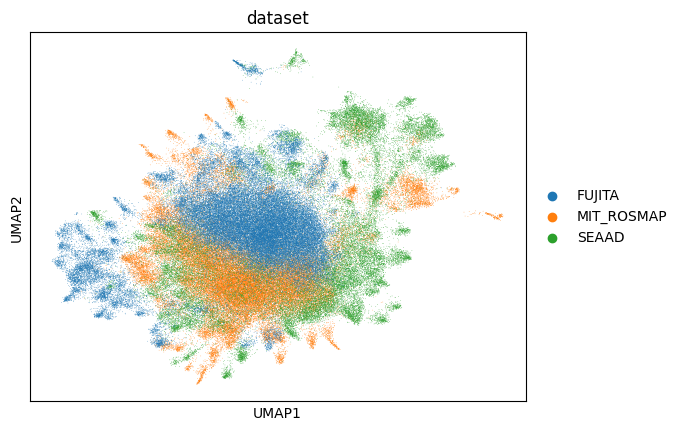

In [2]:
# --- Get latent, neighbors, UMAP, clustering ---
adata.obsm["X_scvi"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["dataset"])       # check batch mixing

Best model params: {'n_hidden': 512, 'n_layers': 2, 'n_latent': 30, 'dropout_rate': 0.1463422937120131}
Best train params: {'max_epochs': 100, 'plan_kwargs': {'lr': 0.0030175780873181, 'n_epochs_kl_warmup': None}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


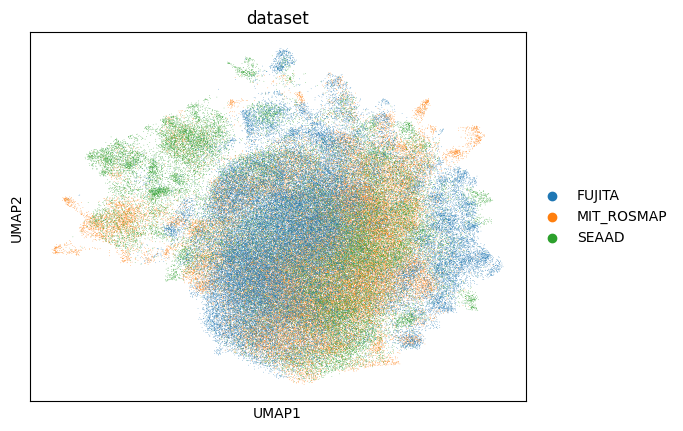

In [9]:
df = pd.read_csv("autotune_results_100/tuning_output.csv")

# Pick the best row (lowest ELBO)
best_row = df.loc[df["elbo_validation"].idxmin()]

# Extract best hyperparameters
best_model_params = {
    "n_hidden": int(best_row["config/model_params/n_hidden"]),
    "n_layers": int(best_row["config/model_params/n_layers"]),
    "n_latent": int(best_row["config/model_params/n_latent"]),
    "dropout_rate": float(best_row["config/model_params/dropout_rate"]),
}

best_train_params = {
    "max_epochs": int(best_row["config/train_params/max_epochs"]),
    "plan_kwargs": {
        "lr": float(best_row["config/train_params/plan_kwargs/lr"]),
        "n_epochs_kl_warmup": (
            None
            if pd.isna(best_row["config/train_params/plan_kwargs/n_epochs_kl_warmup"])
            else int(best_row["config/train_params/plan_kwargs/n_epochs_kl_warmup"])
        ),
    },
}

best_train_params["datasplitter_kwargs"] = {"num_workers": 8}

print("Best model params:", best_model_params)
print("Best train params:", best_train_params)

adata = sc.read_h5ad("merged_microglia.h5ad")
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset") 

best_model = scvi.model.SCVI(adata, **best_model_params)
best_model.train(**best_train_params)

# Save model
best_model.save("best_model_from_autotune", overwrite=True)

# Example: use the trained model
adata.obsm["X_scvi"] = best_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
#sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=["dataset"])       # check batch mixing


In [10]:
import numpy as np
import scanpy as sc

# If you haven't already:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=30)  # tweak k if you like


In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
import scanpy as sc 
import scvi

adata = sc.read_h5ad("merged_microglia.h5ad")
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
print("done with setup")

# Load the saved model
loaded_model = scvi.model.SCVI.load("best_model_from_autotune", adata=adata)
print("done loading model")

# Use it as usual
adata.obsm["X_scvi"] = loaded_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
print("done with neighbors")

X = adata.obsm["X_scvi"]
batches = adata.obs["dataset"].astype(str).values
print("done with getting batches") 

# Global batch silhouette (uses Euclidean distance on X_scvi)
batch_sil_global = silhouette_score(X, batches, metric="euclidean")
print("done with score")
batch_sil_percell = silhouette_samples(X, batches, metric="euclidean")
print("done with per cell")

print(f"[Silhouette] Global batch silhouette (lower=better): {batch_sil_global:.4f}")
print(f"[Silhouette] Per-cell batch silhouette: mean={batch_sil_percell.mean():.4f}, "
      f"median={np.median(batch_sil_percell):.4f}")


done with setup
INFO     File best_model_from_autotune/model.pt already downloaded                                                 
done loading model
done with neighbors
done with getting batches



KeyboardInterrupt



In [6]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

# Latent representation
#X = adata.obsm["X_scvi"]
batches = adata.obs["dataset"].astype("category")
batch_codes = batches.cat.codes.values
n_batches = batches.cat.categories.size

k = 30  

# Subsample (10k cells)
idx = np.random.choice(X.shape[0], size=min(10000, X.shape[0]), replace=False)
X_sub = X[idx]
batch_codes_sub = batch_codes[idx]

# kNN search
nbrs = NearestNeighbors(n_neighbors=k+1, n_jobs=8).fit(X_sub)
indices = nbrs.kneighbors(return_distance=False)[:, 1:]  # drop self

# Compute entropies
entropies = []
for neigh in indices:
    counts = np.bincount(batch_codes_sub[neigh], minlength=n_batches)
    probs = counts / counts.sum()
    ent = entropy(probs) / np.log(n_batches)  # normalize to [0,1]
    entropies.append(ent)

entropies = np.array(entropies)
print(f"[kNN entropy] Mean normalized entropy (higher=better): {entropies.mean():.4f}")
print(f"[kNN entropy] 25/50/75%: {np.percentile(entropies, [25,50,75])}")


[kNN entropy] Mean normalized entropy (higher=better): 0.8007
[kNN entropy] 25/50/75%: [0.72978171 0.83589109 0.92061984]


In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score

batches_sub = adata.obs["dataset"].astype(str).values[idx]
# Global batch silhouette (uses Euclidean distance on X_scvi)
batch_sil_global = silhouette_score(X_sub, batches_sub, metric="euclidean", n_jobs=8)
print("done with score")
batch_sil_percell = silhouette_samples(X_sub, batches_sub, metric="euclidean", n_jobs=8)
print("done with per cell")

print(f"[Silhouette] Global batch silhouette (lower=better): {batch_sil_global:.4f}")
print(f"[Silhouette] Per-cell batch silhouette: mean={batch_sil_percell.mean():.4f}, "
      f"median={np.median(batch_sil_percell):.4f}")

done with score
done with per cell
[Silhouette] Global batch silhouette (lower=better): -0.0128
[Silhouette] Per-cell batch silhouette: mean=-0.0128, median=-0.0002


In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import scanpy as sc 
import scvi

adata = sc.read_h5ad("merged_microglia.h5ad")
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
print("done with setup")

# Load the saved model
loaded_model = scvi.model.SCVI.load("best_model_from_autotune", adata=adata)
print("done loading model")

# Use it as usual
adata.obsm["X_scvi"] = loaded_model.get_latent_representation()
#sc.pp.neighbors(adata, use_rep="X_scvi")
print("done with neighbors")

X = adata.obsm["X_scvi"]
batches = adata.obs["dataset"].astype(str).values
print("done with getting batches") 

# Global batch silhouette (uses Euclidean distance on X_scvi)
batch_sil_global = silhouette_score(X, batches, metric="euclidean")
print("done with score")
batch_sil_percell = silhouette_samples(X, batches, metric="euclidean")
print("done with per cell")

print(f"[Silhouette] Global batch silhouette (lower=better): {batch_sil_global:.4f}")
print(f"[Silhouette] Per-cell batch silhouette: mean={batch_sil_percell.mean():.4f}, "
      f"median={np.median(batch_sil_percell):.4f}")


import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

batches = adata.obs["dataset"].astype("category")
batch_codes = batches.cat.codes.values
n_batches = batches.cat.categories.size

k = 30  

# kNN search
nbrs = NearestNeighbors(n_neighbors=k+1, n_jobs=8).fit(X)
indices = nbrs.kneighbors(return_distance=False)[:, 1:]  # drop self

# Compute entropies
entropies = []
for neigh in indices:
    counts = np.bincount(batch_codes[neigh], minlength=n_batches)
    probs = counts / counts.sum()
    ent = entropy(probs) / np.log(n_batches)  # normalize to [0,1]
    entropies.append(ent)

entropies = np.array(entropies)
print(f"[kNN entropy] Mean normalized entropy (higher=better): {entropies.mean():.4f}")
print(f"[kNN entropy] 25/50/75%: {np.percentile(entropies, [25,50,75])}")


done with setup
INFO     File best_model_from_autotune/model.pt already downloaded                                                 
done loading model
done with neighbors
done with getting batches
done with score
done with per cell
[Silhouette] Global batch silhouette (lower=better): -0.0126
[Silhouette] Per-cell batch silhouette: mean=-0.0126, median=-0.0003
[kNN entropy] Mean normalized entropy (higher=better): 0.6431
[kNN entropy] 25/50/75%: [0.4945082  0.69984441 0.84961174]


In [11]:
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.leiden(adata, resolution=0.5)  # tweak resolution



/tmp/ipykernel_94614/419863257.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # tweak resolution


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

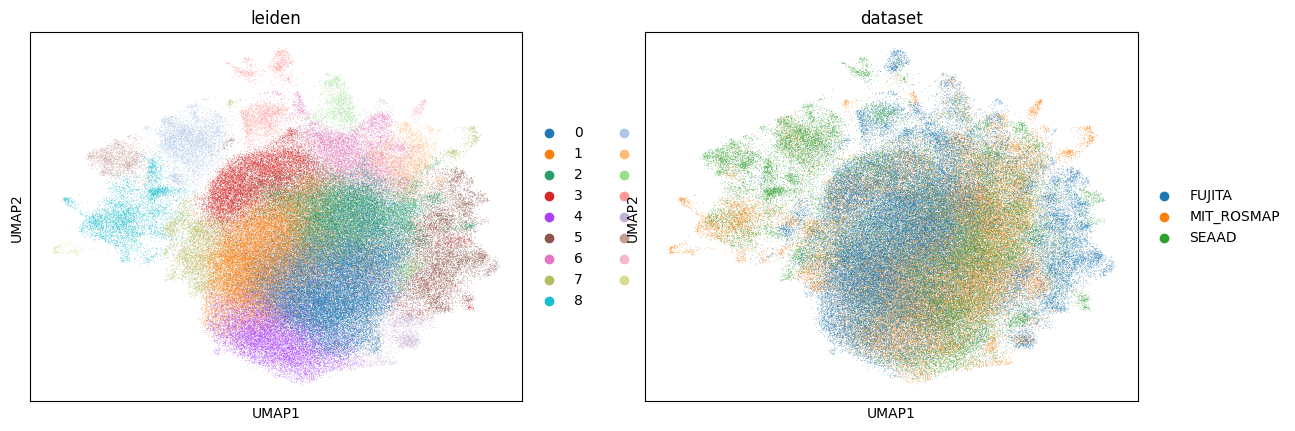

In [12]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "dataset"])

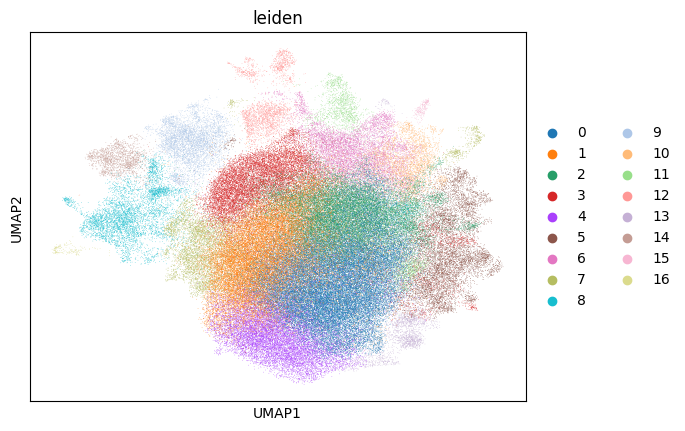

In [13]:
sc.pl.umap(adata, color=["leiden"])

In [14]:
cluster_entropy = {}
for cl in adata.obs["leiden"].unique():
    idx = adata.obs["leiden"] == cl
    cluster_entropy[cl] = entropies[idx].mean()
print(cluster_entropy)


{'1': 0.6626438680397352, '11': 0.718729066822108, '4': 0.6823828937106824, '3': 0.7029644823061891, '5': 0.5221156996776996, '0': 0.7207615937615592, '10': 0.6531201418471018, '8': 0.36271511277617197, '9': 0.5210086877469067, '2': 0.6744668614724811, '7': 0.6176029897156894, '6': 0.5997974016634876, '13': 0.6005924000776253, '12': 0.4030023191446448, '14': 0.41301228485312463, '15': 0.1921950621223672, '16': 0.05798373250579118}


In [ ]:
cluster_entropy = {}
for cl in adata.obs["leiden"].unique():
    idx = adata.obs["leiden"] == cl
    cluster_entropy[cl] = entropies[idx].mean()
print(cluster_entropy)


In [ ]:
# Raw PCA/UMAP
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata, key_added="X_umap_pca")
sc.pl.umap(adata, color="dataset", obsm="X_umap_pca", title="Raw PCA UMAP")

# Already computed: scVI UMAP
sc.pl.umap(adata, color="dataset", title="scVI Latent UMAP")


In [ ]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()


In [ ]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

In [ ]:
adata_scvi = adata_combined.copy()

In [ ]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

In [ ]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)
